# Presentation

### Forest Fire

  This dataset is public available for research. The details are described in [Cortez and Morais, 2007]. 
  Please include this citation if you plan to use this database:

  P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. 
  In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, 
  Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, 
  Guimaraes, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. 
  Available at: http://www.dsi.uminho.pt/~pcortez/fires.pdf

1. Title: Forest Fires

2. Sources
   Created by: Paulo Cortez and An�bal Morais (Univ. Minho) @ 2007
   
3. Past Usage:

   P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data.
   In Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, 
   December, 2007. (http://www.dsi.uminho.pt/~pcortez/fires.pdf)
   
   In the above reference, the output "area" was first transformed with a ln(x+1) function.
   Then, several Data Mining methods were applied. After fitting the models, the outputs were
   post-processed with the inverse of the ln(x+1) transform. Four different input setups were
   used. The experiments were conducted using a 10-fold (cross-validation) x 30 runs. Two
   regression metrics were measured: MAD and RMSE. A Gaussian support vector machine (SVM) fed
   with only 4 direct weather conditions (temp, RH, wind and rain) obtained the best MAD value:
   12.71 +- 0.01 (mean and confidence interval within 95% using a t-student distribution). The
   best RMSE was attained by the naive mean predictor. An analysis to the regression error curve
   (REC) shows that the SVM model predicts more examples within a lower admitted error. In effect,
   the SVM model predicts better small fires, which are the majority. 
 
4. Relevant Information:

   This is a very difficult regression task. It can be used to test regression methods. Also,
   it could be used to test outlier detection methods, since it is not clear how many outliers
   are there. Yet, the number of examples of fires with a large burned area is very small.

5. Number of Instances: 517 

6. Number of Attributes: 12 + output attribute
  
   Note: several of the attributes may be correlated, thus it makes sense to apply some sort of
   feature selection.

7. Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform). 

8. Missing Attribute Values: None

http://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from pandas import scatter_matrix

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer, StandardScaler, Imputer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Exploring datas

In [2]:
csv = pd.read_csv("forestfires.csv")
print(csv.head(), "\n" )
print(csv.info(), "\n")
print(csv.describe(), "\n")

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None 

               

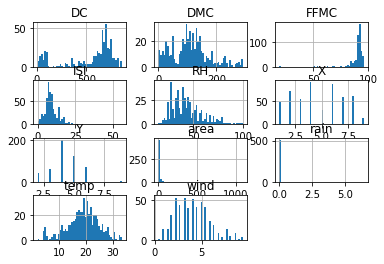

In [3]:
%matplotlib inline
csv.hist(bins=50)
plt.show()

In [4]:
def mapper(month):
    month_to_num = {"jan":1, "feb":2, "mar":3, "apr":4, "may":5, "jun":6, "jul":7, "aug":8, "sep":9, "oct":10, "nov":11, "dec":12}
    return month_to_num[month]

# print(csv["month"].value_counts())
csv['month'] = csv['month'].apply(mapper)
# print(csv["month"].value_counts())

1       2
2      20
3      54
4       9
5       2
6      17
7      32
8     184
9     172
10     15
11      1
12      9
Name: month, dtype: int64


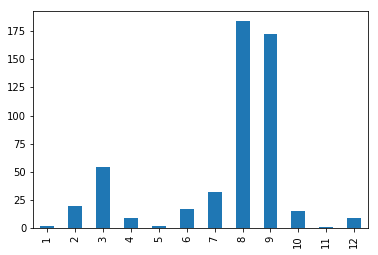

In [5]:
month_data = csv["month"].value_counts().sort_index()
print(month_data)
month_data.plot(kind="bar")
plt.show()

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64


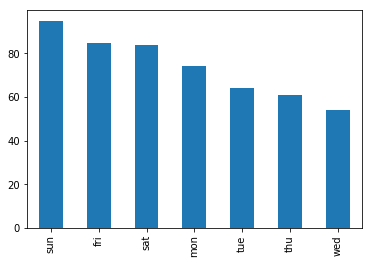

In [6]:
day_data = csv["day"].value_counts()
print(day_data)
day_data.plot(kind="bar")
plt.show()

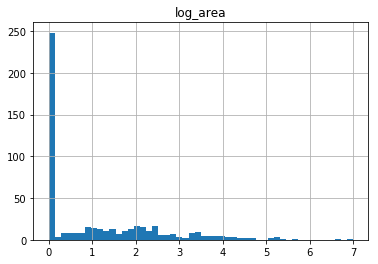

In [7]:
csv["log_area"] = np.log( (csv["area"] + 1) )
csv.hist(column = "log_area", bins = 50)
plt.show()

# 1st Check of Relations

In [8]:
corr_matrix = csv.corr()
print(corr_matrix)

                 X         Y     month      FFMC       DMC        DC  \
X         1.000000  0.539548 -0.065003 -0.021039 -0.048384 -0.085916   
Y         0.539548  1.000000 -0.066292 -0.046308  0.007782 -0.101178   
month    -0.065003 -0.066292  1.000000  0.291477  0.466645  0.868698   
FFMC     -0.021039 -0.046308  0.291477  1.000000  0.382619  0.330512   
DMC      -0.048384  0.007782  0.466645  0.382619  1.000000  0.682192   
DC       -0.085916 -0.101178  0.868698  0.330512  0.682192  1.000000   
ISI       0.006210 -0.024488  0.186597  0.531805  0.305128  0.229154   
temp     -0.051258 -0.024103  0.368842  0.431532  0.469594  0.496208   
RH        0.085223  0.062221 -0.095280 -0.300995  0.073795 -0.039192   
wind      0.018798 -0.020341 -0.086368 -0.028485 -0.105342 -0.203466   
rain      0.065387  0.033234  0.013438  0.056702  0.074790  0.035861   
area      0.063385  0.044873  0.056496  0.040122  0.072994  0.049383   
log_area  0.061995  0.038838  0.114280  0.046799  0.067153  0.06

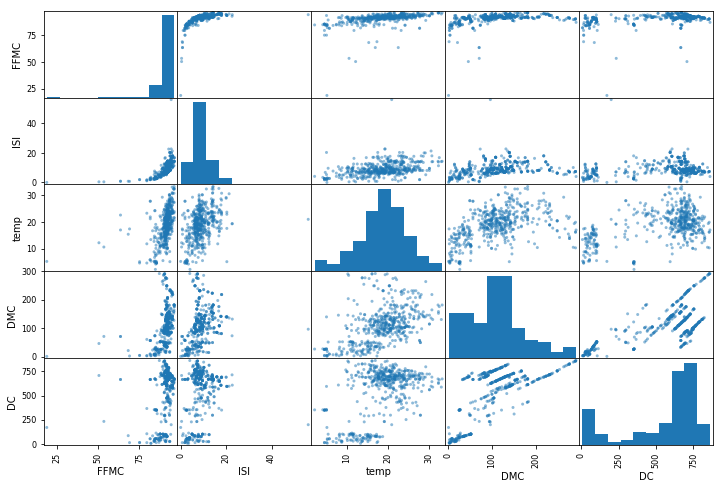

In [9]:
attributes = ["FFMC", "ISI", "temp", "DMC", "DC"]
pd.plotting.scatter_matrix(csv[attributes], figsize = (12,8))
plt.show()

From those relationships, we can see that there is a nice relations between:
- FFMC and temp : linear
- ISI and temp : linear
- FFMC and ISI : logarithmic

Nevertheless, all thoses indicator are based on the same inputs (Temperatures, Relative Humidity, Wind and rain). To simplify the model we can reduce dimensions to only thoses values.

In [10]:
encoder = LabelBinarizer()
day = encoder.fit_transform(csv["day"])
print(day)

[[1 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 [0 0 0 ..., 0 1 0]]


# Splitting Datas

In [11]:
training_set, test_set = train_test_split(csv, test_size=0.2, random_state=42)

In [13]:
real_result = training_set["log_area"].copy()
training_inputs = training_set.drop(["day", "area", "log_area"], axis = 1)
#"X", "Y", "month", "FFMC", "DMC", "DC", "ISI", "area", 
print(training_inputs.head())
print("training size :", training_inputs.shape)
print("result size :", real_result.shape)

     X  Y  month  FFMC    DMC     DC   ISI  temp  RH  wind  rain
329  4  3      9  92.2  102.3  751.5   8.4  23.5  27   4.0   0.0
173  4  4      9  90.9  126.5  686.5   7.0  17.7  39   2.2   0.0
272  2  5      8  92.1  152.6  658.2  14.3  20.2  47   4.0   0.0
497  3  4      8  96.1  181.1  671.2  14.3  32.3  27   2.2   0.0
182  5  4      2  86.8   15.6   48.3   3.9  12.4  53   2.2   0.0
training size : (413, 11)
result size : (413,)


# Feature Scaling

In general cases, we can adjust all feature in 2 ways :
- Min-Max adjustement to scale them all between 0 and 1
- Standardization to center the mean to 0 and a variance of 1

In such case the Standadization makes less sense because datas cannot be negatives (except maybe temperatures)

In [14]:
class DataFrameSlector(BaseEstimator, TransformerMixin):
    def __init__(self, attr_name):
        self.attribute_names = attr_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

In [15]:
pipeline = Pipeline([
    ('std_scaler', MinMaxScaler()),
])

In [16]:
print(training_inputs.head(), "\n")
input_X = pipeline.fit_transform(training_inputs)
print(input_X)

     X  Y  month  FFMC    DMC     DC   ISI  temp  RH  wind  rain
329  4  3      9  92.2  102.3  751.5   8.4  23.5  27   4.0   0.0
173  4  4      9  90.9  126.5  686.5   7.0  17.7  39   2.2   0.0
272  2  5      8  92.1  152.6  658.2  14.3  20.2  47   4.0   0.0
497  3  4      8  96.1  181.1  671.2  14.3  32.3  27   2.2   0.0
182  5  4      2  86.8   15.6   48.3   3.9  12.4  53   2.2   0.0 

[[ 0.375       0.14285714  0.72727273 ...,  0.14117647  0.36470588  0.        ]
 [ 0.375       0.28571429  0.72727273 ...,  0.28235294  0.15294118  0.        ]
 [ 0.125       0.42857143  0.63636364 ...,  0.37647059  0.36470588  0.        ]
 ..., 
 [ 0.125       0.          0.63636364 ...,  0.48235294  0.25882353  0.        ]
 [ 0.125       0.42857143  0.54545455 ...,  0.42352941  0.10588235  0.        ]
 [ 0.125       0.28571429  0.63636364 ...,  0.29411765  0.36470588  0.        ]]


# Running Models

### 1st Model : Linear Regression

In [17]:
# #print(real_result.sort_index())
# index_nonzeros = np.nonzero(real_result)[0]
# print(index_nonzeros)
# some_data_non_zero = input_X[index_nonzeros]
# some_label_non_zero = real_result[index_nonzeros]

# some_data_zero = input_X[np.argwhere(real_result == 0)[:5].flatten()]

# print(some_data_non_zero, "\n" ,some_label_non_zero, "\n" )
# print(some_data_zero)
some_data = input_X[:10]
some_result = real_result[:10]

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(input_X, real_result)

print("Prediction", lin_reg.predict(some_data), "\n")
print("Reality", list(some_result) , "\n")

prediction = lin_reg.predict(input_X)
lin_mse = mean_squared_error(prediction, real_result)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

Prediction [ 1.08905665  1.19948775  0.89540338  1.04770843  0.68647329  0.9703427
  1.13220685  0.85279567  0.81028158  1.02588661] 

Reality [1.4655675420143985, 1.4036429994545037, 1.4085449700547104, 2.7523860149222616, 1.9987736386123811, 0.0, 1.1085626195212777, 0.0, 0.0, 2.5030739537434492] 

1.35073398738


In [19]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(input_X, real_result)

print("Prediction", lin_reg.predict(some_data), "\n")
print("Reality", list(some_result) , "\n")

prediction = tree_reg.predict(input_X)
tree_mse = mean_squared_error(prediction, real_result)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

Prediction [ 1.08905665  1.19948775  0.89540338  1.04770843  0.68647329  0.9703427
  1.13220685  0.85279567  0.81028158  1.02588661] 

Reality [1.4655675420143985, 1.4036429994545037, 1.4085449700547104, 2.7523860149222616, 1.9987736386123811, 0.0, 1.1085626195212777, 0.0, 0.0, 2.5030739537434492] 

0.107153538522


In [20]:
forest_reg = RandomForestRegressor()
forest_reg.fit(input_X, real_result)

print("Prediction", lin_reg.predict(some_data), "\n")
print("Reality", list(some_result) , "\n")

prediction = forest_reg.predict(input_X)
forest_mse = mean_squared_error(prediction, real_result)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

Prediction [ 1.08905665  1.19948775  0.89540338  1.04770843  0.68647329  0.9703427
  1.13220685  0.85279567  0.81028158  1.02588661] 

Reality [1.4655675420143985, 1.4036429994545037, 1.4085449700547104, 2.7523860149222616, 1.9987736386123811, 0.0, 1.1085626195212777, 0.0, 0.0, 2.5030739537434492] 

0.652807399443


In [21]:
linear_svr = SVR(kernel='linear', C=1e3)
linear_svr.fit(input_X, real_result)

print("Prediction", lin_reg.predict(some_data), "\n")
print("Reality", list(some_result) , "\n")

prediction = linear_svr.predict(input_X)
lin_svr_mse = mean_squared_error(prediction, real_result)
lin_svr_rmse = np.sqrt(lin_svr_mse)
print(lin_svr_rmse)

Prediction [ 1.08905665  1.19948775  0.89540338  1.04770843  0.68647329  0.9703427
  1.13220685  0.85279567  0.81028158  1.02588661] 

Reality [1.4655675420143985, 1.4036429994545037, 1.4085449700547104, 2.7523860149222616, 1.9987736386123811, 0.0, 1.1085626195212777, 0.0, 0.0, 2.5030739537434492] 

1.44305616198


In [22]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(input_X, real_result)

print("Prediction", lin_reg.predict(some_data), "\n")
print("Reality", list(some_result) , "\n")

prediction = svr_rbf.predict(input_X)
svr_rbf_mse = mean_squared_error(prediction, real_result)
svr_rbf_rmse = np.sqrt(svr_rbf_mse)
print(svr_rbf_rmse)

Prediction [ 1.08905665  1.19948775  0.89540338  1.04770843  0.68647329  0.9703427
  1.13220685  0.85279567  0.81028158  1.02588661] 

Reality [1.4655675420143985, 1.4036429994545037, 1.4085449700547104, 2.7523860149222616, 1.9987736386123811, 0.0, 1.1085626195212777, 0.0, 0.0, 2.5030739537434492] 

1.33719914445


# Fine tunes a model

In [23]:
param_grid = [
    {'C': [0.1, 1, 10, 100], 'epsilon': [0.05, 0.1, 0.15], "gamma": [0.1, 0.05, 0.2]},
  ]

svr_rbf = SVR(kernel='rbf')

grid_search = GridSearchCV(svr_rbf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(input_X, real_result)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'C': [0.1, 1, 10, 100], 'epsilon': [0.05, 0.1, 0.15], 'gamma': [0.1, 0.05, 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [24]:
print("Best", grid_search.best_params_, "\n")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best {'C': 10, 'epsilon': 0.15, 'gamma': 0.2} 

1.54510450262 {'C': 0.1, 'epsilon': 0.05, 'gamma': 0.1}
1.54776885099 {'C': 0.1, 'epsilon': 0.05, 'gamma': 0.05}
1.54117409968 {'C': 0.1, 'epsilon': 0.05, 'gamma': 0.2}
1.54226059855 {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.1}
1.54208331608 {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.05}
1.54276417399 {'C': 0.1, 'epsilon': 0.1, 'gamma': 0.2}
1.54248066178 {'C': 0.1, 'epsilon': 0.15, 'gamma': 0.1}
1.54245814178 {'C': 0.1, 'epsilon': 0.15, 'gamma': 0.05}
1.54107038823 {'C': 0.1, 'epsilon': 0.15, 'gamma': 0.2}
1.51934134585 {'C': 1, 'epsilon': 0.05, 'gamma': 0.1}
1.52798947051 {'C': 1, 'epsilon': 0.05, 'gamma': 0.05}
1.50874928605 {'C': 1, 'epsilon': 0.05, 'gamma': 0.2}
1.51079439593 {'C': 1, 'epsilon': 0.1, 'gamma': 0.1}
1.52253381212 {'C': 1, 'epsilon': 0.1, 'gamma': 0.05}
1.50344771418 {'C': 1, 'epsilon': 0.1, 'gamma': 0.2}
1.50759625027 {'C': 1, 'epsilon': 0.15, 'gamma': 0.1}
1.51386208747 {'C': 1, 'epsilon': 0.15, 'gamma': 0.05}
1.49985113581 {'

In [26]:
param_grid = [
    {'C': [10, 100, 1000], 'epsilon': [0.15, 0.25, 0.4], "gamma": [0.2, 0.25, 0.3]},
  ]

svr_rbf = SVR(kernel='rbf')

grid_search = GridSearchCV(svr_rbf, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(input_X, real_result)
print("Best", grid_search.best_params_, "\n")
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best {'C': 10, 'epsilon': 0.4, 'gamma': 0.2} 

1.4813526063 {'C': 10, 'epsilon': 0.15, 'gamma': 0.2}
1.48361393331 {'C': 10, 'epsilon': 0.15, 'gamma': 0.25}
1.488168316 {'C': 10, 'epsilon': 0.15, 'gamma': 0.3}
1.46699862124 {'C': 10, 'epsilon': 0.25, 'gamma': 0.2}
1.47105550915 {'C': 10, 'epsilon': 0.25, 'gamma': 0.25}
1.4760824887 {'C': 10, 'epsilon': 0.25, 'gamma': 0.3}
1.45047022178 {'C': 10, 'epsilon': 0.4, 'gamma': 0.2}
1.45112663972 {'C': 10, 'epsilon': 0.4, 'gamma': 0.25}
1.45328379246 {'C': 10, 'epsilon': 0.4, 'gamma': 0.3}
1.54371014936 {'C': 100, 'epsilon': 0.15, 'gamma': 0.2}
1.55717547906 {'C': 100, 'epsilon': 0.15, 'gamma': 0.25}
1.57961586126 {'C': 100, 'epsilon': 0.15, 'gamma': 0.3}
1.52128380093 {'C': 100, 'epsilon': 0.25, 'gamma': 0.2}
1.54719832712 {'C': 100, 'epsilon': 0.25, 'gamma': 0.25}
1.56885634171 {'C': 100, 'epsilon': 0.25, 'gamma': 0.3}
1.49741574479 {'C': 100, 'epsilon': 0.4, 'gamma': 0.2}
1.5164056532 {'C': 100, 'epsilon': 0.4, 'gamma': 0.25}
1.54073248939 

In [27]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_epsilon,param_gamma,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.005611,0.000511,-2.194406,-1.932923,10,0.15,0.2,"{'C': 10, 'epsilon': 0.15, 'gamma': 0.2}",7,-2.200126,...,-2.740172,-1.816327,-2.601223,-1.755205,-1.569643,-2.026224,0.000511,4.595253e-04,0.439245,0.130274
1,0.005206,0.000597,-2.201110,-1.908859,10,0.15,0.25,"{'C': 10, 'epsilon': 0.15, 'gamma': 0.25}",8,-2.182840,...,-2.731781,-1.787081,-2.608724,-1.719556,-1.591385,-1.998704,0.000389,4.872111e-04,0.427922,0.140873
2,0.005429,0.000494,-2.214645,-1.883786,10,0.15,0.3,"{'C': 10, 'epsilon': 0.15, 'gamma': 0.3}",9,-2.200235,...,-2.748206,-1.772324,-2.632255,-1.690552,-1.610363,-1.965293,0.000387,3.066553e-04,0.432318,0.136058
3,0.005096,0.000601,-2.152085,-1.923243,10,0.25,0.2,"{'C': 10, 'epsilon': 0.25, 'gamma': 0.2}",4,-2.134008,...,-2.704833,-1.802448,-2.586314,-1.764548,-1.556066,-2.013747,0.000380,2.005587e-04,0.444603,0.124875
4,0.005210,0.000696,-2.164004,-1.897800,10,0.25,0.25,"{'C': 10, 'epsilon': 0.25, 'gamma': 0.25}",5,-2.150629,...,-2.719241,-1.777906,-2.580960,-1.727294,-1.563336,-1.990281,0.000514,2.498058e-04,0.440731,0.126736
5,0.005415,0.000598,-2.178820,-1.873695,10,0.25,0.3,"{'C': 10, 'epsilon': 0.25, 'gamma': 0.3}",6,-2.159290,...,-2.751265,-1.762900,-2.598374,-1.698464,-1.564642,-1.965308,0.000202,1.991230e-04,0.449349,0.123379
6,0.005020,0.000602,-2.103864,-1.906925,10,0.4,0.2,"{'C': 10, 'epsilon': 0.4, 'gamma': 0.2}",1,-2.069990,...,-2.636345,-1.767325,-2.524792,-1.766617,-1.529578,-2.025061,0.000442,2.003198e-04,0.426714,0.120602
7,0.005114,0.000702,-2.105769,-1.869677,10,0.4,0.25,"{'C': 10, 'epsilon': 0.4, 'gamma': 0.25}",2,-2.082454,...,-2.662181,-1.742795,-2.520192,-1.711886,-1.525214,-1.988840,0.000199,2.439658e-04,0.436699,0.121994
8,0.005213,0.000502,-2.112034,-1.832566,10,0.4,0.3,"{'C': 10, 'epsilon': 0.4, 'gamma': 0.3}",3,-2.114670,...,-2.685957,-1.717967,-2.511287,-1.666653,-1.521532,-1.930684,0.000244,2.276866e-06,0.444155,0.118572
9,0.009525,0.000492,-2.383041,-1.749938,100,0.15,0.2,"{'C': 100, 'epsilon': 0.15, 'gamma': 0.2}",14,-2.345372,...,-3.275145,-1.640759,-2.783266,-1.564628,-1.646030,-1.821074,0.000450,1.238217e-05,0.595463,0.131248


# Evaluation

In [31]:
final_model = grid_search.best_estimator_

X_test = test_set.drop(["day", "area", "log_area"], axis=1)
# "X", "Y", "month", , "FFMC", "DMC", "DC", "ISI",
y_test = test_set["log_area"].copy()
y_test_init = test_set["area"].copy()

X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_predictions_init = np.exp(final_predictions)

print("\n")
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("RMSE :", final_rmse)

final_mad = mean_absolute_error(y_test, final_predictions)
print("MAD", final_mad)

print("\n")
final_mse = mean_squared_error(y_test_init, final_predictions_init)
final_rmse = np.sqrt(final_mse)
print("RMSE :", final_rmse)

final_mad = mean_absolute_error(y_test_init, final_predictions_init)
print("MAD", final_mad)

y_print = y_test.values.reshape(-1,1).flatten()
print()
for i in range(20):
    print("{:3f} vs {:3f}".format(y_print[i], final_predictions[i]))

0.000000 vs 0.593101
0.000000 vs 0.671023
0.802002 vs 1.095069
0.900161 vs 0.383882
1.081805 vs 0.675453
0.000000 vs 0.279686
2.707383 vs 0.268390
2.006871 vs 0.368977
0.000000 vs 0.874939
0.559616 vs 0.357808
0.000000 vs 0.922961
1.000632 vs 0.519981
0.000000 vs 0.557595
0.000000 vs 0.413189
0.000000 vs 0.943442
1.690096 vs 0.524138
0.000000 vs 0.305939
0.000000 vs 0.225168
2.074429 vs 0.554082
2.399712 vs 0.647800


RMSE : 1.5439760428
MAD 1.10207925854


RMSE : 109.969639098
MAD 19.6359470941
